# Check out Pb fields from test runs

In [2]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from math import sin, cos, sqrt, atan2, radians
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import pickle
import matplotlib
import xarray as xr

%matplotlib inline

#### Parameters:

In [3]:
# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179

# Resolution of grid cells to show in figure:
grid_reso  = 10

land_color  = '#a9a7a2'

#### Load files:

In [4]:
mfile    = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20220317.nc')
mesh_lon = np.array(mfile.variables['nav_lon'])
mesh_lat = np.array(mfile.variables['nav_lat'])
mask     = np.array(mfile.variables['tmask'][0])
mesh_bathy   = np.array(mfile.variables['tmask'][0,:,:,:])
bathy_masked = np.ma.masked_where((mesh_bathy> 0.1), mesh_bathy)
mesh_depth   = np.array(mfile.variables['nav_lev'])

In [17]:
folder1 = '/data/brogalla/run_storage/Pb-tuning-202210/Pb-tuning-202210-new-fill-particle0005-kscav10/'
f1      = xr.open_dataset(f'{folder1}ANHA12_EXH006_5d_20150101_20151231_ptrc_T_20151212-20151216.nc')
dpbf1   = f1['dissolpb'].values

folder2 = '/data/brogalla/run_storage/Pb-tuning-202210/Pb-tuning-202210-new-fill-particle0005-kscav10-1/'
f2      = xr.open_dataset(f'{folder2}ANHA12_EXH006_5d_20150101_20151231_ptrc_T_20150106-20150110.nc')
dpbf2   = f2['dissolpb'].values

folder3 = '/data/brogalla/run_storage/Pb-tuning-202210/Pb-tuning-202210-new-ini-particle0005-kscav-off/'
f3      = xr.open_dataset(f'{folder1}ANHA12_EXH006_5d_20150101_20151231_ptrc_T_20151222-20151226.nc')
dpbf3   = f3['dissolpb'].values

In [19]:
print(np.amin(dpbf1), np.argwhere(dpbf1 < 0))
# print(np.amin(dpbf2), np.argwhere(dpbf2 < 0))
# print(np.amin(dpbf3), np.argwhere(dpbf3 < 0))

-1.1531715e-14 [[  0  20 719  48]
 [  0  20 720  48]
 [  0  20 720  49]
 [  0  20 721  48]
 [  0  20 721  49]]


In [21]:
a = np.argwhere(dpbf1<0)

In [26]:
[print(i) for i in a]

[  0  20 719  48]
[  0  20 720  48]
[  0  20 720  49]
[  0  20 721  48]
[  0  20 721  49]


[None, None, None, None, None]

## Look at negative concentration locations in 3D

X is longitude, Y is latitude, Z is depth, and the values shown are the bathy.

In [32]:
sub_bathy = mesh_bathy[:,imin:imax,jmin:jmax]

I want Z to be only the values of the first land grid cell? 

In [107]:
# indices where dpb concentration goes negative
issue_ind = np.argwhere(dpbf1 < 0)
issue_x   = np.array([ind[2] for ind in issue_ind])
issue_y   = np.array([ind[3] for ind in issue_ind])
issue_z   = np.array([ind[1] for ind in issue_ind])

In [108]:
grid_x = np.arange(715,725,1)
grid_y = np.arange(40,60,1)

X, Y = np.meshgrid(grid_x, grid_y)
Z    = sub_bathy[:,715:725,40:60]

Z_bottom = np.zeros(X.shape)
for x in range(0,len(grid_x)-1):
    for y in range(0,len(grid_y)-1):
        z_bot = np.min(np.argwhere(Z[:,x,y] < 1))
        Z_bottom[y,x] = z_bot

(30.0, 0.0)

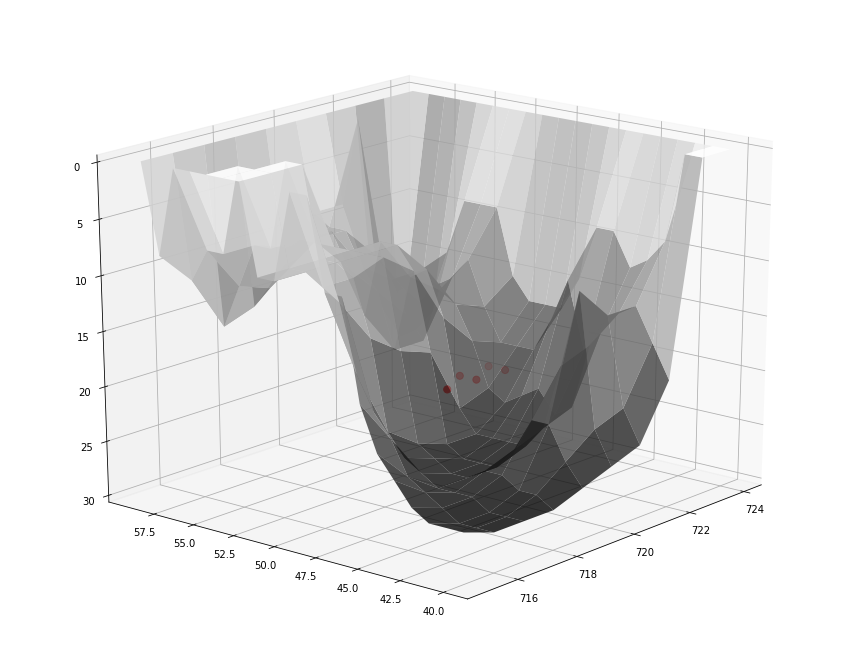

In [104]:
fig = plt.figure(figsize=(15,12))
ax  = plt.axes(projection='3d')
ax.view_init(20, -140)

ax.plot_surface(X, Y, Z_bottom, rstride=1, cstride=1, cmap='binary', edgecolor='none', alpha=0.8)
ax.scatter3D(issue_x, issue_y, issue_z, c='r', s=50)

ax.set_zlim(30,0)    # issue around 20

In [109]:
x_sub = (715,725)
y_sub = (44,54)

grid_x = np.arange(x_sub[0],x_sub[1],1)
grid_y = np.arange(y_sub[0],y_sub[1],1)

X, Y = np.meshgrid(grid_x, grid_y)
Z    = sub_bathy[:,x_sub[0]:x_sub[1],y_sub[0]:y_sub[1]]

Z_bottom = np.zeros(X.shape)
for x in range(0,len(grid_x)-1):
    for y in range(0,len(grid_y)-1):
        z_bot = np.min(np.argwhere(Z[:,x,y] < 1))
        Z_bottom[y,x] = z_bot

In [126]:
sub_bathy[issue_z, issue_x, issue_y]

array([1, 1, 1, 1, 1], dtype=int8)

(30.0, 0.0)

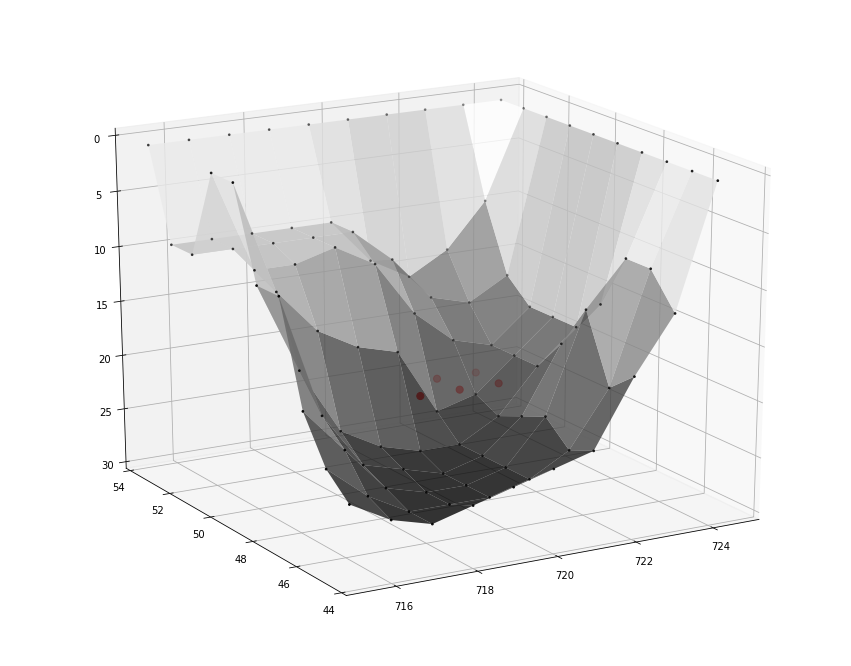

In [124]:
fig = plt.figure(figsize=(15,12))
ax  = plt.axes(projection='3d')
ax.view_init(20, -120)

ax.plot_surface(X, Y, Z_bottom, rstride=1, cstride=1, cmap='binary', edgecolor='none', alpha=0.8)
ax.scatter3D(X, Y, Z_bottom, c='k', s=3)
ax.scatter3D(issue_x, issue_y, issue_z, c='r', s=50)

ax.set_xlim(x_sub[0], x_sub[1]) # issue around 719-721
ax.set_ylim(y_sub[0], y_sub[1]) # issue around 48-49
ax.set_zlim(30,0)    # issue around 20

In [20]:
mesh_bathy.shape

(50, 2400, 1632)

## Value print outs

In [5]:
def load_comps(folder, month=1):
    
    comp = nc.Dataset(f'{folder}ANHA12_EXH006_1m_20150101_20151231_comp_2015{month:02}-2015{month:02}.nc')

    dpb         = np.array(comp.variables['dissolpb'])[:,:,:]
    dpb_sed     = np.array(comp.variables['dpbsed'])[:,:,:]
    dpb_sedice  = np.array(comp.variables['dpbsedice'])[:,:,:]
    dpb_ads     = np.array(comp.variables['dpbads'])[:,:,:]
    dpb_icedust = np.array(comp.variables['dpbicedust'])[:,:,:]
    dpb_icebc   = np.array(comp.variables['dpbicebc'])[:,:,:]
    dpb_atmdust = np.array(comp.variables['dpbatmdust'])[:,:,:]
    dpb_atmbc   = np.array(comp.variables['dpbatmbc'])[:,:,:]
    dpb_riv     = np.array(comp.variables['dpbriv'])[:,:,:]

    print(f'----------------- Month: {month:02} ----------------------------')
    print(f'Resuspension:    {np.mean(dpb_sed):.2e} ({np.amin(dpb_sed):.2e}  - {np.amax(dpb_sed):.2e})')
    print(f'Sediment ice:    {np.mean(dpb_sedice):.2e} ({np.amin(dpb_sedice):.2e}  - {np.amax(dpb_sedice):.2e})')
    print(f'Adsorption:      {np.mean(dpb_ads):.2e} ({np.amin(dpb_ads):.2e}  - {np.amax(dpb_ads):.2e})')
    print(f'Ice flux dust:   {np.mean(dpb_icedust):.2e} ({np.amin(dpb_icedust):.2e}  - {np.amax(dpb_icedust):.2e})')
    print(f'Ice flux bc:     {np.mean(dpb_icebc):.2e} ({np.amin(dpb_icebc):.2e}  - {np.amax(dpb_icebc):.2e})')
    print(f'Atmosphere dust: {np.mean(dpb_atmdust):.2e} ({np.amin(dpb_atmdust):.2e}  - {np.amax(dpb_atmdust):.2e})')
    print(f'Atmosphere bc:   {np.mean(dpb_atmbc):.2e} ({np.amin(dpb_atmbc):.2e}  - {np.amax(dpb_atmbc):.2e})')
    print(f'River runoff:    {np.mean(dpb_riv):.2e} ({np.amin(dpb_riv):.2e}  - {np.amax(dpb_riv):.2e})')
    
    return dpb, dpb_sed, dpb_sedice, dpb_ads, \
            dpb_icedust, dpb_icebc, dpb_atmdust, dpb_atmbc, \
            dpb_riv

In [17]:
folder = '/data/brogalla/run_storage/Pb-tuning-202210/Pb-tuning-202210-new-fill-particle0005-kscav10/'
dpb01, dpb_sed01, dpb_sedice01, dpb_ads01, dpb_icedust01, dpb_icebc01, dpb_atmdust01, dpb_atmbc01, \
            dpb_riv01 = load_comps(folder, month=9)
dpb02, dpb_sed02, dpb_sedice02, dpb_ads02, dpb_icedust02, dpb_icebc02, dpb_atmdust02, dpb_atmbc02, \
            dpb_riv02 = load_comps(folder, month=10)
dpb03, dpb_sed03, dpb_sedice03, dpb_ads03, dpb_icedust03, dpb_icebc03, dpb_atmdust03, dpb_atmbc03, \
            dpb_riv03 = load_comps(folder, month=11)
dpb04, dpb_sed04, dpb_sedice04, dpb_ads04, dpb_icedust04, dpb_icebc04, dpb_atmdust04, dpb_atmbc04, \
            dpb_riv04 = load_comps(folder, month=12)

----------------- Month: 09 ----------------------------
Resuspension:    8.06e-19 (0.00e+00  - 1.05e-16)
Sediment ice:    1.49e-18 (0.00e+00  - 9.65e-17)
Adsorption:      1.14e-19 (0.00e+00  - 2.24e-17)
Ice flux dust:   1.95e-19 (0.00e+00  - 1.75e-18)
Ice flux bc:     1.55e-18 (0.00e+00  - 1.40e-17)
Atmosphere dust: 3.06e-19 (5.27e-21  - 8.18e-19)
Atmosphere bc:   6.40e-18 (6.17e-20  - 2.46e-17)
River runoff:    1.84e-19 (0.00e+00  - 2.11e-15)
----------------- Month: 10 ----------------------------
Resuspension:    8.06e-19 (0.00e+00  - 1.05e-16)
Sediment ice:    2.00e-19 (0.00e+00  - 1.37e-16)
Adsorption:      4.77e-20 (0.00e+00  - 1.46e-17)
Ice flux dust:   5.42e-20 (0.00e+00  - 8.40e-19)
Ice flux bc:     2.29e-19 (0.00e+00  - 3.26e-18)
Atmosphere dust: 2.01e-19 (3.28e-21  - 9.00e-19)
Atmosphere bc:   5.24e-18 (2.61e-20  - 3.38e-17)
River runoff:    1.44e-19 (0.00e+00  - 1.60e-15)
----------------- Month: 11 ----------------------------
Resuspension:    8.06e-19 (0.00e+00  - 1.05e-

In [19]:
print(np.argwhere(dpb01 < 0))
print(np.argwhere(dpb02 < 0))
print(np.argwhere(dpb03 < 0))
print(np.argwhere(dpb04 < 0))

[]
[]
[]
[]


In [54]:
def print_scav(dpth, coord1, coord2):

    print(f'All for one location ({coord1},{coord2}) 3 depths, 4 months:')
    print('---------- [Dissolved Pb] ------------')
    print(f'{dpb01[0,dpth-1,coord1,coord2]:.2e}, {dpb02[0,dpth-1,coord1,coord2]:.2e}, {dpb03[0,dpth-1,coord1,coord2]:.2e}, {dpb04[0,dpth-1,coord1,coord2]:.2e}')
    print(f'{dpb01[0,dpth,coord1,coord2]:.2e}, {dpb02[0,dpth,coord1,coord2]:.2e}, {dpb03[0,dpth,coord1,coord2]:.2e}, {dpb04[0,dpth,coord1,coord2]:.2e}')
    print(f'{dpb01[0,dpth+1,coord1,coord2]:.2e}, {dpb02[0,dpth+1,coord1,coord2]:.2e}, {dpb03[0,dpth+1,coord1,coord2]:.2e}, {dpb04[0,dpth+1,coord1,coord2]:.2e}')
    print('---------- Pb adsorption print out ------------')
    print(f'{dpb_ads01[0,dpth-1,coord1,coord2]*3600*24*30:.2e}, {dpb_ads02[0,dpth-1,coord1,coord2]*3600*24*30:.2e}, {dpb_ads03[0,dpth-1,coord1,coord2]*3600*24*30:.2e}' + \
          f', {dpb_ads04[0,dpth-1,coord1,coord2]*3600*24*30:.2e}')
    print(f'{dpb_ads01[0,dpth,coord1,coord2]*3600*24*30:.2e}, {dpb_ads02[0,dpth,coord1,coord2]*3600*24*30:.2e}, {dpb_ads03[0,dpth,coord1,coord2]*3600*24*30:.2e}' + \
          f', {dpb_ads04[0,dpth,coord1,coord2]*3600*24*30:.2e}')
    print(f'{dpb_ads01[0,dpth+1,coord1,coord2]*3600*24*30:.2e}, {dpb_ads02[0,dpth+1,coord1,coord2]*3600*24*30:.2e}, {dpb_ads03[0,dpth+1,coord1,coord2]*3600*24*30:.2e}' + \
          f', {dpb_ads04[0,dpth+1,coord1,coord2]*3600*24*30:.2e}')
    print('---------- Calculated scavenging ------------')
    print(f'{calc_scav(dpb01[0,dpth-1,coord1,coord2],scav_litho01[dpth-1,coord1,coord2],scav_bio01[dpth-1,coord1,coord2]):.2e}, '+\
          f'{calc_scav(dpb02[0,dpth-1,coord1,coord2],scav_litho02[dpth-1,coord1,coord2],scav_bio02[dpth-1,coord1,coord2]):.2e}, '+\
          f'{calc_scav(dpb03[0,dpth-1,coord1,coord2],scav_litho03[dpth-1,coord1,coord2],scav_bio03[dpth-1,coord1,coord2]):.2e}, '+\
          f'{calc_scav(dpb04[0,dpth-1,coord1,coord2],scav_litho04[dpth-1,coord1,coord2],scav_bio04[dpth-1,coord1,coord2]):.2e}')
    print(f'{calc_scav(dpb01[0,dpth,coord1,coord2],scav_litho01[dpth,coord1,coord2],scav_bio01[dpth,coord1,coord2]):.2e}, '+\
          f'{calc_scav(dpb02[0,dpth,coord1,coord2],scav_litho02[dpth,coord1,coord2],scav_bio02[dpth,coord1,coord2]):.2e}, '+\
          f'{calc_scav(dpb03[0,dpth,coord1,coord2],scav_litho03[dpth,coord1,coord2],scav_bio03[dpth,coord1,coord2]):.2e}, '+\
          f'{calc_scav(dpb04[0,dpth,coord1,coord2],scav_litho04[dpth,coord1,coord2],scav_bio04[dpth,coord1,coord2]):.2e}')
    print(f'{calc_scav(dpb01[0,dpth+1,coord1,coord2],scav_litho01[dpth+1,coord1,coord2],scav_bio01[dpth+1,coord1,coord2]):.2e}, '+\
          f'{calc_scav(dpb02[0,dpth+1,coord1,coord2],scav_litho02[dpth+1,coord1,coord2],scav_bio02[dpth+1,coord1,coord2]):.2e}, '+\
          f'{calc_scav(dpb03[0,dpth+1,coord1,coord2],scav_litho03[dpth+1,coord1,coord2],scav_bio03[dpth+1,coord1,coord2]):.2e}, '+\
          f'{calc_scav(dpb04[0,dpth+1,coord1,coord2],scav_litho04[dpth+1,coord1,coord2],scav_bio04[dpth+1,coord1,coord2]):.2e}')
    print('---------- Particle forcing bio ------------')
    print(f'{scav_bio01[dpth-1,coord1,coord2]:.2e}, {scav_bio02[dpth-1,coord1,coord2]:.2e}, {scav_bio03[dpth-1,coord1,coord2]:.2e}, {scav_bio04[dpth-1,coord1,coord2]:.2e}')
    print(f'{scav_bio01[dpth,coord1,coord2]:.2e}, {scav_bio02[dpth,coord1,coord2]:.2e}, {scav_bio03[dpth,coord1,coord2]:.2e}, {scav_bio04[dpth,coord1,coord2]:.2e}')
    print(f'{scav_bio01[dpth+1,coord1,coord2]:.2e}, {scav_bio02[dpth+1,coord1,coord2]:.2e}, {scav_bio03[dpth+1,coord1,coord2]:.2e}, {scav_bio04[dpth+1,coord1,coord2]:.2e}')
    print('---------- Particle forcing litho ------------')
    print(f'{scav_litho01[dpth-1,coord1,coord2]:.2e}, {scav_litho02[dpth-1,coord1,coord2]:.2e}, {scav_litho03[dpth-1,coord1,coord2]:.2e}, {scav_litho04[dpth-1,coord1,coord2]:.2e}')
    print(f'{scav_litho01[dpth,coord1,coord2]:.2e}, {scav_litho02[dpth,coord1,coord2]:.2e}, {scav_litho03[dpth,coord1,coord2]:.2e}, {scav_litho04[dpth,coord1,coord2]:.2e}')
    print(f'{scav_litho01[dpth+1,coord1,coord2]:.2e}, {scav_litho02[dpth+1,coord1,coord2]:.2e}, {scav_litho03[dpth+1,coord1,coord2]:.2e}, {scav_litho04[dpth+1,coord1,coord2]:.2e}')
    
    return

In [55]:
print_scav(25, 117, 450)

All for one location (117,450) 3 depths, 4 months:
---------- [Dissolved Pb] ------------
4.69e-13, 6.60e-15, 3.01e-14, 1.71e-13
8.14e-13, -1.68e-15, 8.33e-14, 3.77e-13
3.95e-12, 3.22e-13, 4.84e-13, 7.65e-13
---------- Pb adsorption print out ------------
1.64e-12, 2.61e-14, 5.75e-14, 7.48e-14
1.60e-12, -3.39e-15, 9.39e-14, 8.42e-14
3.62e-12, 3.14e-13, 1.78e-13, 1.44e-13
---------- Calculated scavenging ------------
1.64e-12, 2.61e-14, 5.75e-14, 7.48e-14
1.60e-12, -3.39e-15, 9.39e-14, 8.42e-14
2.04e-11, 1.66e-12, 2.50e-12, 3.95e-12
---------- Particle forcing bio ------------
6.72e-02, 7.62e-02, 3.67e-02, 8.35e-03
3.78e-02, 3.89e-02, 2.17e-02, 4.24e-03
9.95e-02, 9.95e-02, 9.95e-02, 9.95e-02
---------- Particle forcing litho ------------
5.02e-05, 3.89e-05, 4.93e-05, 7.23e-05
5.29e-05, 4.01e-05, 5.50e-05, 6.78e-05
6.20e-05, 5.66e-05, 7.30e-05, 7.24e-05


In [56]:
print_scav(25, 224, 492)

All for one location (224,492) 3 depths, 4 months:
---------- [Dissolved Pb] ------------
5.94e-12, 1.09e-12, 6.22e-14, 9.54e-14
7.29e-12, 2.28e-12, -7.20e-15, 8.73e-14
8.11e-12, 3.78e-12, 2.50e-13, 2.09e-13
---------- Pb adsorption print out ------------
3.07e-12, 4.70e-13, 2.91e-14, 4.78e-14
2.98e-12, 7.81e-13, -2.66e-15, 3.46e-14
2.57e-12, 1.00e-12, 7.12e-14, 6.39e-14
---------- Calculated scavenging ------------
3.07e-12, 4.70e-13, 2.91e-14, 4.78e-14
2.98e-12, 7.81e-13, -2.66e-15, 3.46e-14
2.57e-12, 1.00e-12, 7.12e-14, 6.39e-14
---------- Particle forcing bio ------------
9.87e-03, 8.24e-03, 8.88e-03, 9.49e-03
7.77e-03, 6.50e-03, 7.00e-03, 7.48e-03
5.99e-03, 5.00e-03, 5.39e-03, 5.76e-03
---------- Particle forcing litho ------------
1.06e-04, 1.06e-04, 1.30e-04, 1.74e-04
1.12e-04, 1.07e-04, 1.17e-04, 1.58e-04
1.20e-04, 1.13e-04, 1.09e-04, 1.26e-04


In [63]:
print_scav(20, 173, 438)

All for one location (173,438) 3 depths, 4 months:
---------- [Dissolved Pb] ------------
6.28e-12, 4.89e-13, -4.41e-15, -3.34e-15
7.21e-12, 6.59e-13, -1.35e-14, 1.91e-14
8.37e-12, 1.01e-12, 3.08e-13, 4.39e-13
---------- Pb adsorption print out ------------
5.32e-12, 1.88e-12, -1.32e-14, -8.96e-15
5.56e-12, 2.31e-12, -3.69e-14, 4.68e-14
5.62e-12, 3.10e-12, 7.31e-13, 9.36e-13
---------- Calculated scavenging ------------
5.32e-12, 1.88e-12, -1.32e-14, -8.96e-15
5.56e-12, 2.31e-12, -3.69e-14, 4.68e-14
5.62e-12, 3.10e-12, 7.31e-13, 9.36e-13
---------- Particle forcing bio ------------
1.62e-02, 7.40e-02, 5.75e-02, 5.17e-02
1.47e-02, 6.75e-02, 5.25e-02, 4.71e-02
1.28e-02, 5.88e-02, 4.56e-02, 4.10e-02
---------- Particle forcing litho ------------
1.82e-04, 1.17e-04, 5.71e-05, 4.12e-05
1.64e-04, 1.39e-04, 7.16e-05, 6.42e-05
1.60e-04, 1.49e-04, 1.33e-04, 1.47e-04


In [33]:
print(dpb03[0,24,117,450])
print(dpb03[0,25,117,450])
print(dpb03[0,26,117,450])
print(dpb03[0,27,117,450])
print(dpb03[0,28,117,450])
print(dpb03[0,29,117,450])
print('--')
print(dpb03[0,24,118,450])
print(dpb03[0,25,118,450])
print(dpb03[0,26,118,450])
print(dpb03[0,27,118,450])
print(dpb03[0,28,118,450])
print(dpb03[0,29,118,450])
print('--')
print(dpb03[0,24,116,450])
print(dpb03[0,25,116,450])
print(dpb03[0,26,116,450])
print(dpb03[0,27,116,450])
print(dpb03[0,28,116,450])
print(dpb03[0,29,116,450])
print('--')
print(dpb03[0,24,117,451])
print(dpb03[0,25,117,451])
print(dpb03[0,26,117,451])
print(dpb03[0,27,117,451])
print(dpb03[0,28,117,451])
print(dpb03[0,29,117,451])
print('--')
print(dpb03[0,24,117,449])
print(dpb03[0,25,117,449])
print(dpb03[0,26,117,449])
print(dpb03[0,27,117,449])
print(dpb03[0,28,117,449])
print(dpb03[0,29,117,449])

3.0132367e-14
8.329977e-14
4.8407995e-13
7.381325e-13
1.2324857e-12
0.0
--
4.9132265e-14
0.0
0.0
0.0
0.0
0.0
--
2.3416765e-14
8.96527e-14
4.5473304e-13
8.036254e-13
1.1870566e-12
0.0
--
0.0
0.0
0.0
0.0
0.0
0.0
--
2.4979254e-14
4.6478534e-14
4.17675e-13
0.0
0.0
0.0


In [48]:
dpb_neg = np.copy(dpb03[0,:,:,:])
dpb_neg[dpb03[0,:,:,:] >= 0] = np.nan
dpb_neg_loc = np.nansum(dpb_neg, axis=0)

# create mask based on where the negative values are:
dpb_neg_values = np.ma.masked_where(dpb03[0,:,:,:] < 0, dpb03[0,:,:,:])
dpb_neg_3D_mask = dpb_neg_values.mask
dpb_neg_2D_mask = np.ma.masked_where(dpb_neg_loc!=0, dpb_neg_loc).mask

In [26]:
print('---------- [Dissolved Pb] ------------')
print(f'{dpb01[0,22,740,35]:.2e}, {dpb02[0,22,740,35]:.2e}, {dpb03[0,22,740,35]:.2e}')
print(f'{dpb01[0,23,740,35]:.2e}, {dpb02[0,23,740,35]:.2e}, {dpb03[0,23,740,35]:.2e}')
print(f'{dpb01[0,24,740,35]:.2e}, {dpb02[0,24,740,35]:.2e}, {dpb03[0,24,740,35]:.2e}')

print('---------- Pb_ads ------------')
print(f'{dpb_ads01[0,22,740,35]:.2e}, {dpb_ads02[0,22,740,35]:.2e}, {dpb_ads03[0,22,740,35]:.2e}')
print(f'{dpb_ads01[0,23,740,35]:.2e}, {dpb_ads02[0,23,740,35]:.2e}, {dpb_ads03[0,23,740,35]:.2e}')
print(f'{dpb_ads01[0,24,740,35]:.2e}, {dpb_ads02[0,24,740,35]:.2e}, {dpb_ads03[0,24,740,35]:.2e}')

---------- [Dissolved Pb] ------------
4.99e-12, 4.95e-12, 4.92e-12
2.64e-12, 5.54e-13, -7.83e-15
0.00e+00, 0.00e+00, 0.00e+00
---------- Pb_ads ------------
9.12e-22, 1.07e-21, 1.26e-21
1.31e-18, 2.76e-19, -3.90e-21
0.00e+00, 0.00e+00, 0.00e+00


In [37]:
# calculate what scavenging removal should approximately equal at particular location:

def calc_scav(dpb, litho, bio):
    kscav = 2.0e-5 # 1/s
    # dpb in mol/L
    
    removal = kscav*(litho + bio)*dpb
    
    monthly_removal = removal*3600*24*30
    
    return monthly_removal

In [60]:
print('All for one location (718,45) 3 depths, 4 months:')
print('---------- [Dissolved Pb] ------------')
print(f'{dpb01[0,24,718,45]:.2e}, {dpb02[0,24,718,45]:.2e}, {dpb03[0,24,718,45]:.2e}, {dpb04[0,24,718,45]:.2e}')
print(f'{dpb01[0,25,718,45]:.2e}, {dpb02[0,25,718,45]:.2e}, {dpb03[0,25,718,45]:.2e}, {dpb04[0,25,718,45]:.2e}')
print(f'{dpb01[0,26,718,45]:.2e}, {dpb02[0,26,718,45]:.2e}, {dpb03[0,26,718,45]:.2e}, {dpb04[0,26,718,45]:.2e}')
print('---------- Pb adsorption print out ------------')
print(f'{dpb_ads01[0,24,718,45]*3600*24*30:.2e}, {dpb_ads02[0,24,718,45]*3600*24*30:.2e}, {dpb_ads03[0,24,718,45]*3600*24*30:.2e}' + \
      f', {dpb_ads04[0,24,718,45]*3600*24*30:.2e}')
print(f'{dpb_ads01[0,25,718,45]*3600*24*30:.2e}, {dpb_ads02[0,25,718,45]*3600*24*30:.2e}, {dpb_ads03[0,25,718,45]*3600*24*30:.2e}' + \
      f', {dpb_ads04[0,25,718,45]*3600*24*30:.2e}')
print(f'{dpb_ads01[0,26,718,45]*3600*24*30:.2e}, {dpb_ads02[0,26,718,45]*3600*24*30:.2e}, {dpb_ads03[0,26,718,45]*3600*24*30:.2e}' + \
      f', {dpb_ads04[0,26,718,45]*3600*24*30:.2e}')
print('---------- Calculated scavenging ------------')
print(f'{calc_scav(dpb01[0,24,718,45],scav_litho01[24,718,45],scav_bio01[24,718,45]):.2e}, '+\
      f'{calc_scav(dpb02[0,24,718,45],scav_litho02[24,718,45],scav_bio02[24,718,45]):.2e}, '+\
      f'{calc_scav(dpb03[0,24,718,45],scav_litho03[24,718,45],scav_bio03[24,718,45]):.2e}, '+\
      f'{calc_scav(dpb04[0,24,718,45],scav_litho04[24,718,45],scav_bio04[24,718,45]):.2e}')
print(f'{calc_scav(dpb01[0,25,718,45],scav_litho01[25,718,45],scav_bio01[25,718,45]):.2e}, '+\
      f'{calc_scav(dpb02[0,25,718,45],scav_litho02[25,718,45],scav_bio02[25,718,45]):.2e}, '+\
      f'{calc_scav(dpb03[0,25,718,45],scav_litho03[25,718,45],scav_bio03[25,718,45]):.2e}, '+\
      f'{calc_scav(dpb04[0,25,718,45],scav_litho04[25,718,45],scav_bio04[25,718,45]):.2e}')
print(f'{calc_scav(dpb01[0,26,718,45],scav_litho01[26,718,45],scav_bio01[26,718,45]):.2e}, '+\
      f'{calc_scav(dpb02[0,26,718,45],scav_litho02[26,718,45],scav_bio02[26,718,45]):.2e}, '+\
      f'{calc_scav(dpb03[0,26,718,45],scav_litho03[26,718,45],scav_bio03[26,718,45]):.2e}, '+\
      f'{calc_scav(dpb04[0,26,718,45],scav_litho04[26,718,45],scav_bio04[26,718,45]):.2e}')
print('---------- Particle forcing bio ------------')
print(f'{scav_bio01[24,718,45]:.2e}, {scav_bio02[24,718,45]:.2e}, {scav_bio03[24,718,45]:.2e}, {scav_bio04[24,718,45]:.2e}')
print(f'{scav_bio01[25,718,45]:.2e}, {scav_bio02[25,718,45]:.2e}, {scav_bio03[25,718,45]:.2e}, {scav_bio04[25,718,45]:.2e}')
print(f'{scav_bio01[26,718,45]:.2e}, {scav_bio02[26,718,45]:.2e}, {scav_bio03[26,718,45]:.2e}, {scav_bio04[26,718,45]:.2e}')
print('---------- Particle forcing litho ------------')
print(f'{scav_litho01[24,718,45]:.2e}, {scav_litho02[24,718,45]:.2e}, {scav_litho03[24,718,45]:.2e}, {scav_litho04[24,718,45]:.2e}')
print(f'{scav_litho01[25,718,45]:.2e}, {scav_litho02[25,718,45]:.2e}, {scav_litho03[25,718,45]:.2e}, {scav_litho04[25,718,45]:.2e}')
print(f'{scav_litho01[26,718,45]:.2e}, {scav_litho02[26,718,45]:.2e}, {scav_litho03[26,718,45]:.2e}, {scav_litho04[26,718,45]:.2e}')

All for one location (718,45) 3 depths, 4 months:
---------- [Dissolved Pb] ------------
4.49e-12, 3.52e-12, 2.93e-12, 2.45e-12
2.57e-12, 5.07e-13, -2.24e-15, -1.03e-13
0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
---------- Pb adsorption print out ------------
2.86e-15, 2.25e-15, 2.29e-15, 3.29e-13
3.32e-12, 6.55e-13, -2.89e-15, -1.33e-13
0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
---------- Calculated scavenging ------------
2.86e-15, 2.25e-15, 2.29e-15, 3.29e-13
3.32e-12, 6.55e-13, -2.89e-15, -1.33e-13
0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
---------- Particle forcing bio ------------
1.15e-07, 3.70e-07, 1.05e-05, 1.03e-02
9.95e-02, 9.95e-02, 9.95e-02, 9.95e-02
9.95e-02, 9.95e-02, 9.95e-02, 9.95e-02
---------- Particle forcing litho ------------
4.90e-05, 4.88e-05, 4.97e-05, 5.13e-05
5.52e-05, 5.40e-05, 5.28e-05, 5.25e-05
0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00


In [66]:
print('All for one location (718,45) 3 depths, 4 months:')
print('---------- [Dissolved Pb] ------------')
print(f'{dpb01[0,24,718,45]:.2e}, {dpb02[0,24,718,45]:.2e}, {dpb03[0,24,718,45]:.2e}, {dpb04[0,24,718,45]:.2e}')
print(f'{dpb01[0,25,718,45]:.2e}, {dpb02[0,25,718,45]:.2e}, {dpb03[0,25,718,45]:.2e}, {dpb04[0,25,718,45]:.2e}')
print(f'{dpb01[0,26,718,45]:.2e}, {dpb02[0,26,718,45]:.2e}, {dpb03[0,26,718,45]:.2e}, {dpb04[0,26,718,45]:.2e}')
print('---------- Pb adsorption print out ------------')
print(f'{dpb_ads01[0,24,718,45]*3600*24*30:.2e}, {dpb_ads02[0,24,718,45]*3600*24*30:.2e}, {dpb_ads03[0,24,718,45]*3600*24*30:.2e}' + \
      f', {dpb_ads04[0,24,718,45]*3600*24*30:.2e}')
print(f'{dpb_ads01[0,25,718,45]*3600*24*30:.2e}, {dpb_ads02[0,25,718,45]*3600*24*30:.2e}, {dpb_ads03[0,25,718,45]*3600*24*30:.2e}' + \
      f', {dpb_ads04[0,25,718,45]*3600*24*30:.2e}')
print(f'{dpb_ads01[0,26,718,45]*3600*24*30:.2e}, {dpb_ads02[0,26,718,45]*3600*24*30:.2e}, {dpb_ads03[0,26,718,45]*3600*24*30:.2e}' + \
      f', {dpb_ads04[0,26,718,45]*3600*24*30:.2e}')
print('---------- Calculated scavenging ------------')
print(f'{calc_scav(dpb01[0,24,718,45],scav1_litho01[24,718,45],scav1_bio01[24,718,45]):.2e}, '+\
      f'{calc_scav(dpb02[0,24,718,45],scav1_litho02[24,718,45],scav1_bio02[24,718,45]):.2e}, '+\
      f'{calc_scav(dpb03[0,24,718,45],scav1_litho03[24,718,45],scav1_bio03[24,718,45]):.2e}, '+\
      f'{calc_scav(dpb04[0,24,718,45],scav1_litho04[24,718,45],scav1_bio04[24,718,45]):.2e}')
print(f'{calc_scav(dpb01[0,25,718,45],scav1_litho01[25,718,45],scav1_bio01[25,718,45]):.2e}, '+\
      f'{calc_scav(dpb02[0,25,718,45],scav1_litho02[25,718,45],scav1_bio02[25,718,45]):.2e}, '+\
      f'{calc_scav(dpb03[0,25,718,45],scav1_litho03[25,718,45],scav1_bio03[25,718,45]):.2e}, '+\
      f'{calc_scav(dpb04[0,25,718,45],scav1_litho04[25,718,45],scav1_bio04[25,718,45]):.2e}')
print(f'{calc_scav(dpb01[0,26,718,45],scav1_litho01[26,718,45],scav1_bio01[26,718,45]):.2e}, '+\
      f'{calc_scav(dpb02[0,26,718,45],scav1_litho02[26,718,45],scav1_bio02[26,718,45]):.2e}, '+\
      f'{calc_scav(dpb03[0,26,718,45],scav1_litho03[26,718,45],scav1_bio03[26,718,45]):.2e}, '+\
      f'{calc_scav(dpb04[0,26,718,45],scav1_litho04[26,718,45],scav1_bio04[26,718,45]):.2e}')
print('---------- Particle forcing bio ------------')
print(f'{scav1_bio01[24,718,45]:.2e}, {scav1_bio02[24,718,45]:.2e}, {scav1_bio03[24,718,45]:.2e}, {scav1_bio04[24,718,45]:.2e}')
print(f'{scav1_bio01[25,718,45]:.2e}, {scav1_bio02[25,718,45]:.2e}, {scav1_bio03[25,718,45]:.2e}, {scav1_bio04[25,718,45]:.2e}')
print(f'{scav1_bio01[26,718,45]:.2e}, {scav1_bio02[26,718,45]:.2e}, {scav1_bio03[26,718,45]:.2e}, {scav1_bio04[26,718,45]:.2e}')
print('---------- Particle forcing litho ------------')
print(f'{scav1_litho01[24,718,45]:.2e}, {scav1_litho02[24,718,45]:.2e}, {scav1_litho03[24,718,45]:.2e}, {scav1_litho04[24,718,45]:.2e}')
print(f'{scav1_litho01[25,718,45]:.2e}, {scav1_litho02[25,718,45]:.2e}, {scav1_litho03[25,718,45]:.2e}, {scav1_litho04[25,718,45]:.2e}')
print(f'{scav1_litho01[26,718,45]:.2e}, {scav1_litho02[26,718,45]:.2e}, {scav1_litho03[26,718,45]:.2e}, {scav1_litho04[26,718,45]:.2e}')

All for one location (718,45) 3 depths, 4 months:
---------- [Dissolved Pb] ------------
4.49e-12, 3.52e-12, 2.93e-12, 2.45e-12
2.57e-12, 5.07e-13, -2.24e-15, -1.03e-13
0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
---------- Pb adsorption print out ------------
2.86e-15, 2.25e-15, 2.29e-15, 3.29e-13
3.32e-12, 6.55e-13, -2.89e-15, -1.33e-13
0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
---------- Calculated scavenging ------------
2.86e-15, 2.25e-15, 2.29e-15, 3.29e-13
1.84e-15, 3.57e-16, -1.84e-18, -1.39e-14
0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
---------- Particle forcing bio ------------
1.15e-07, 3.70e-07, 1.05e-05, 1.03e-02
1.15e-07, 3.70e-07, 1.05e-05, 1.03e-02
0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
---------- Particle forcing litho ------------
4.90e-05, 4.88e-05, 4.97e-05, 5.13e-05
5.52e-05, 5.40e-05, 5.28e-05, 5.25e-05
0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00


Scavenging calculated based on the forcing gives the same amount of removal as the model prints out, so the model does seem to do what I think it should be doing. 

In [63]:
print('All for one location (740, 35) 3 depths, 4 months:')
print('---------- [Dissolved Pb] ------------')
print(f'{dpb01[0,22,740,35]:.2e}, {dpb02[0,22,740,35]:.2e}, {dpb03[0,22,740,35]:.2e}, {dpb04[0,22,740,35]:.2e}')
print(f'{dpb01[0,23,740,35]:.2e}, {dpb02[0,23,740,35]:.2e}, {dpb03[0,23,740,35]:.2e}, {dpb04[0,23,740,35]:.2e}')
print(f'{dpb01[0,24,740,35]:.2e}, {dpb02[0,24,740,35]:.2e}, {dpb03[0,24,740,35]:.2e}, {dpb04[0,24,740,35]:.2e}')
print('---------- Pb adsorption print out ------------')
print(f'{dpb_ads01[0,22,740,35]*3600*24*30:.2e}, {dpb_ads02[0,22,740,35]*3600*24*30:.2e}, {dpb_ads03[0,22,740,35]*3600*24*30:.2e}' + \
      f', {dpb_ads04[0,22,740,35]*3600*24*30:.2e}')
print(f'{dpb_ads01[0,23,740,35]*3600*24*30:.2e}, {dpb_ads02[0,23,740,35]*3600*24*30:.2e}, {dpb_ads03[0,23,740,35]*3600*24*30:.2e}' + \
      f', {dpb_ads04[0,23,740,35]*3600*24*30:.2e}')
print(f'{dpb_ads01[0,24,740,35]*3600*24*30:.2e}, {dpb_ads02[0,24,740,35]*3600*24*30:.2e}, {dpb_ads03[0,24,740,35]*3600*24*30:.2e}' + \
      f', {dpb_ads04[0,24,740,35]*3600*24*30:.2e}')
print('---------- Calculated scavenging ------------')
print(f'{calc_scav(dpb01[0,22,740,35],scav_litho01[22,740,35],scav_bio01[22,740,35]):.2e}, '+\
      f'{calc_scav(dpb02[0,22,740,35],scav_litho02[22,740,35],scav_bio02[22,740,35]):.2e}, '+\
      f'{calc_scav(dpb03[0,22,740,35],scav_litho03[22,740,35],scav_bio03[22,740,35]):.2e}, '+\
      f'{calc_scav(dpb04[0,22,740,35],scav_litho04[22,740,35],scav_bio04[22,740,35]):.2e}')
print(f'{calc_scav(dpb01[0,23,740,35],scav_litho01[23,740,35],scav_bio01[23,740,35]):.2e}, '+\
      f'{calc_scav(dpb02[0,23,740,35],scav_litho02[23,740,35],scav_bio02[23,740,35]):.2e}, '+\
      f'{calc_scav(dpb03[0,23,740,35],scav_litho03[23,740,35],scav_bio03[23,740,35]):.2e}, '+\
      f'{calc_scav(dpb04[0,23,740,35],scav_litho04[23,740,35],scav_bio04[23,740,35]):.2e}')
print(f'{calc_scav(dpb01[0,24,740,35],scav_litho01[24,740,35],scav_bio01[24,740,35]):.2e}, '+\
      f'{calc_scav(dpb02[0,24,740,35],scav_litho02[24,740,35],scav_bio02[24,740,35]):.2e}, '+\
      f'{calc_scav(dpb03[0,24,740,35],scav_litho03[24,740,35],scav_bio03[24,740,35]):.2e}, '+\
      f'{calc_scav(dpb04[0,24,740,35],scav_litho04[24,740,35],scav_bio04[24,740,35]):.2e}')
print('---------- Particle forcing bio ------------')
print(f'{scav_bio01[22,740,35]:.2e}, {scav_bio02[22,740,35]:.2e}, {scav_bio03[22,740,35]:.2e}, {scav_bio04[22,740,35]:.2e}')
print(f'{scav_bio01[23,740,35]:.2e}, {scav_bio02[23,740,35]:.2e}, {scav_bio03[23,740,35]:.2e}, {scav_bio04[23,740,35]:.2e}')
print(f'{scav_bio01[24,740,35]:.2e}, {scav_bio02[24,740,35]:.2e}, {scav_bio03[24,740,35]:.2e}, {scav_bio04[24,740,35]:.2e}')
print('---------- Particle forcing litho ------------')
print(f'{scav_litho01[22,740,35]:.2e}, {scav_litho02[22,740,35]:.2e}, {scav_litho03[22,740,35]:.2e}, {scav_litho04[22,740,35]:.2e}')
print(f'{scav_litho01[23,740,35]:.2e}, {scav_litho02[23,740,35]:.2e}, {scav_litho03[23,740,35]:.2e}, {scav_litho04[23,740,35]:.2e}')
print(f'{scav_litho01[24,740,35]:.2e}, {scav_litho02[24,740,35]:.2e}, {scav_litho03[24,740,35]:.2e}, {scav_litho04[24,740,35]:.2e}')

All for one location (740, 35) 3 depths, 4 months:
---------- [Dissolved Pb] ------------
4.99e-12, 4.95e-12, 4.92e-12, 4.51e-12
2.64e-12, 5.54e-13, -7.83e-15, -1.56e-13
0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
---------- Pb adsorption print out ------------
2.36e-15, 2.78e-15, 3.26e-15, 6.34e-13
3.41e-12, 7.14e-13, -1.01e-14, -2.02e-13
0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
---------- Calculated scavenging ------------
2.36e-15, 2.78e-15, 3.26e-15, 6.34e-13
3.41e-12, 7.14e-13, -1.01e-14, -2.02e-13
0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
---------- Particle forcing bio ------------
9.81e-08, 6.75e-07, 5.87e-06, 1.08e-02
9.95e-02, 9.95e-02, 9.95e-02, 9.95e-02
9.95e-02, 9.95e-02, 9.95e-02, 9.95e-02
---------- Particle forcing litho ------------
3.65e-05, 4.27e-05, 4.54e-05, 4.53e-05
3.29e-05, 3.55e-05, 3.93e-05, 4.30e-05
0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00


In [67]:
print('All for one location (740, 35) 3 depths, 4 months:')
print('---------- [Dissolved Pb] ------------')
print(f'{dpb01[0,22,740,35]:.2e}, {dpb02[0,22,740,35]:.2e}, {dpb03[0,22,740,35]:.2e}, {dpb04[0,22,740,35]:.2e}')
print(f'{dpb01[0,23,740,35]:.2e}, {dpb02[0,23,740,35]:.2e}, {dpb03[0,23,740,35]:.2e}, {dpb04[0,23,740,35]:.2e}')
print(f'{dpb01[0,24,740,35]:.2e}, {dpb02[0,24,740,35]:.2e}, {dpb03[0,24,740,35]:.2e}, {dpb04[0,24,740,35]:.2e}')
print('---------- Pb adsorption print out ------------')
print(f'{dpb_ads01[0,22,740,35]*3600*24*30:.2e}, {dpb_ads02[0,22,740,35]*3600*24*30:.2e}, {dpb_ads03[0,22,740,35]*3600*24*30:.2e}' + \
      f', {dpb_ads04[0,22,740,35]*3600*24*30:.2e}')
print(f'{dpb_ads01[0,23,740,35]*3600*24*30:.2e}, {dpb_ads02[0,23,740,35]*3600*24*30:.2e}, {dpb_ads03[0,23,740,35]*3600*24*30:.2e}' + \
      f', {dpb_ads04[0,23,740,35]*3600*24*30:.2e}')
print(f'{dpb_ads01[0,24,740,35]*3600*24*30:.2e}, {dpb_ads02[0,24,740,35]*3600*24*30:.2e}, {dpb_ads03[0,24,740,35]*3600*24*30:.2e}' + \
      f', {dpb_ads04[0,24,740,35]*3600*24*30:.2e}')
print('---------- Calculated scavenging ------------')
print(f'{calc_scav(dpb01[0,22,740,35],scav1_litho01[22,740,35],scav1_bio01[22,740,35]):.2e}, '+\
      f'{calc_scav(dpb02[0,22,740,35],scav1_litho02[22,740,35],scav1_bio02[22,740,35]):.2e}, '+\
      f'{calc_scav(dpb03[0,22,740,35],scav1_litho03[22,740,35],scav1_bio03[22,740,35]):.2e}, '+\
      f'{calc_scav(dpb04[0,22,740,35],scav1_litho04[22,740,35],scav1_bio04[22,740,35]):.2e}')
print(f'{calc_scav(dpb01[0,23,740,35],scav1_litho01[23,740,35],scav1_bio01[23,740,35]):.2e}, '+\
      f'{calc_scav(dpb02[0,23,740,35],scav1_litho02[23,740,35],scav1_bio02[23,740,35]):.2e}, '+\
      f'{calc_scav(dpb03[0,23,740,35],scav1_litho03[23,740,35],scav1_bio03[23,740,35]):.2e}, '+\
      f'{calc_scav(dpb04[0,23,740,35],scav1_litho04[23,740,35],scav1_bio04[23,740,35]):.2e}')
print(f'{calc_scav(dpb01[0,24,740,35],scav1_litho01[24,740,35],scav1_bio01[24,740,35]):.2e}, '+\
      f'{calc_scav(dpb02[0,24,740,35],scav1_litho02[24,740,35],scav1_bio02[24,740,35]):.2e}, '+\
      f'{calc_scav(dpb03[0,24,740,35],scav1_litho03[24,740,35],scav1_bio03[24,740,35]):.2e}, '+\
      f'{calc_scav(dpb04[0,24,740,35],scav1_litho04[24,740,35],scav1_bio04[24,740,35]):.2e}')
print('---------- Particle forcing bio ------------')
print(f'{scav1_bio01[22,740,35]:.2e}, {scav1_bio02[22,740,35]:.2e}, {scav1_bio03[22,740,35]:.2e}, {scav1_bio04[22,740,35]:.2e}')
print(f'{scav1_bio01[23,740,35]:.2e}, {scav1_bio02[23,740,35]:.2e}, {scav1_bio03[23,740,35]:.2e}, {scav1_bio04[23,740,35]:.2e}')
print(f'{scav1_bio01[24,740,35]:.2e}, {scav1_bio02[24,740,35]:.2e}, {scav1_bio03[24,740,35]:.2e}, {scav1_bio04[24,740,35]:.2e}')
print('---------- Particle forcing litho ------------')
print(f'{scav1_litho01[22,740,35]:.2e}, {scav1_litho02[22,740,35]:.2e}, {scav1_litho03[22,740,35]:.2e}, {scav1_litho04[22,740,35]:.2e}')
print(f'{scav1_litho01[23,740,35]:.2e}, {scav1_litho02[23,740,35]:.2e}, {scav1_litho03[23,740,35]:.2e}, {scav1_litho04[23,740,35]:.2e}')
print(f'{scav1_litho01[24,740,35]:.2e}, {scav1_litho02[24,740,35]:.2e}, {scav1_litho03[24,740,35]:.2e}, {scav1_litho04[24,740,35]:.2e}')

All for one location (740, 35) 3 depths, 4 months:
---------- [Dissolved Pb] ------------
4.99e-12, 4.95e-12, 4.92e-12, 4.51e-12
2.64e-12, 5.54e-13, -7.83e-15, -1.56e-13
0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
---------- Pb adsorption print out ------------
2.36e-15, 2.78e-15, 3.26e-15, 6.34e-13
3.41e-12, 7.14e-13, -1.01e-14, -2.02e-13
0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
---------- Calculated scavenging ------------
2.36e-15, 2.78e-15, 3.26e-15, 6.34e-13
1.13e-15, 2.60e-16, -4.58e-18, -2.20e-14
0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
---------- Particle forcing bio ------------
9.81e-08, 6.75e-07, 5.87e-06, 1.08e-02
9.81e-08, 6.75e-07, 5.87e-06, 1.08e-02
0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
---------- Particle forcing litho ------------
3.65e-05, 4.27e-05, 4.54e-05, 4.53e-05
3.29e-05, 3.55e-05, 3.93e-05, 4.30e-05
0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00


Maybe instead of filling it with 0.10 as a fill value, I should be filling the biogenic particle fields with whatever the content of the nearest non-zero cell is?

In [45]:
print('---------- [Dissolved Pb] ------------')
print('--- one location multiple depths:')
print(f'{dpb01[0,24,718,45]:.2e}, {dpb02[0,24,718,45]:.2e}, {dpb03[0,24,718,45]:.2e}')
print(f'{dpb01[0,25,718,45]:.2e}, {dpb02[0,25,718,45]:.2e}, {dpb03[0,25,718,45]:.2e}')
print(f'{dpb01[0,26,718,45]:.2e}, {dpb02[0,26,718,45]:.2e}, {dpb03[0,26,718,45]:.2e}')
print('--- surrounding locations same depth:')
print(f'{dpb01[0,25,719,45]:.2e}, {dpb02[0,25,719,45]:.2e}, {dpb03[0,25,719,45]:.2e}, {dpb04[0,25,719,45]:.2e}')
print(f'{dpb01[0,25,717,45]:.2e}, {dpb02[0,25,717,45]:.2e}, {dpb03[0,25,717,45]:.2e}, {dpb04[0,25,717,45]:.2e}')
print(f'{dpb01[0,25,718,46]:.2e}, {dpb02[0,25,718,46]:.2e}, {dpb03[0,25,718,46]:.2e}, {dpb04[0,25,718,46]:.2e}')
print(f'{dpb01[0,25,718,44]:.2e}, {dpb02[0,25,718,44]:.2e}, {dpb03[0,25,718,44]:.2e}, {dpb04[0,25,718,44]:.2e}')
print('')
print('---------- Pb_ads ------------')
print('--- one location multiple depths:')
print(f'{dpb_ads01[0,24,718,45]:.2e}, {dpb_ads02[0,24,718,45]:.2e}, {dpb_ads03[0,24,718,45]:.2e}')
print(f'{dpb_ads01[0,25,718,45]:.2e}, {dpb_ads02[0,25,718,45]:.2e}, {dpb_ads03[0,25,718,45]:.2e}')
print(f'{dpb_ads01[0,26,718,45]:.2e}, {dpb_ads02[0,26,718,45]:.2e}, {dpb_ads03[0,26,718,45]:.2e}')
print('--- one location multiple depths: litho fraction')
print(f'{scav_litho01[24,718,45]:.2e}, {scav_litho02[24,718,45]:.2e}, {scav_litho03[24,718,45]:.2e}')
print(f'{scav_litho01[25,718,45]:.2e}, {scav_litho02[25,718,45]:.2e}, {scav_litho03[25,718,45]:.2e}')
print(f'{scav_litho01[26,718,45]:.2e}, {scav_litho02[26,718,45]:.2e}, {scav_litho03[26,718,45]:.2e}')
print('--- one location multiple depths: bio fraction')
print(f'{scav_bio01[24,718,45]:.2e}, {scav_bio02[24,718,45]:.2e}, {scav_bio03[24,718,45]:.2e}')
print(f'{scav_bio01[25,718,45]:.2e}, {scav_bio02[25,718,45]:.2e}, {scav_bio03[25,718,45]:.2e}')
print(f'{scav_bio01[26,718,45]:.2e}, {scav_bio02[26,718,45]:.2e}, {scav_bio03[26,718,45]:.2e}')
print('--- surrounding locations same depth:')
print(f'{dpb_ads01[0,25,719,45]:.2e}, {dpb_ads02[0,25,719,45]:.2e}, {dpb_ads03[0,25,719,45]:.2e}, {dpb_ads04[0,25,719,45]:.2e}')
print(f'{dpb_ads01[0,25,717,45]:.2e}, {dpb_ads02[0,25,717,45]:.2e}, {dpb_ads03[0,25,717,45]:.2e}, {dpb_ads04[0,25,717,45]:.2e}')
print(f'{dpb_ads01[0,25,718,46]:.2e}, {dpb_ads02[0,25,718,46]:.2e}, {dpb_ads03[0,25,718,46]:.2e}, {dpb_ads04[0,25,718,46]:.2e}')
print(f'{dpb_ads01[0,25,718,44]:.2e}, {dpb_ads02[0,25,718,44]:.2e}, {dpb_ads03[0,25,718,44]:.2e}, {dpb_ads04[0,25,718,44]:.2e}')
print('--- surrounding locations same depth: litho fraction')
print(f'{scav_litho01[25,719,45]:.2e}, {scav_litho02[25,719,45]:.2e}, {scav_litho03[25,719,45]:.2e}, {scav_litho04[25,719,45]:.2e}')
print(f'{scav_litho01[25,717,45]:.2e}, {scav_litho02[25,717,45]:.2e}, {scav_litho03[25,717,45]:.2e}, {scav_litho04[25,717,45]:.2e}')
print(f'{scav_litho01[25,718,46]:.2e}, {scav_litho02[25,718,46]:.2e}, {scav_litho03[25,718,46]:.2e}, {scav_litho04[25,718,46]:.2e}')
print(f'{scav_litho01[25,718,44]:.2e}, {scav_litho02[25,718,44]:.2e}, {scav_litho03[25,718,44]:.2e}, {scav_litho04[25,718,44]:.2e}')
print('--- surrounding locations same depth: bio fraction')
print(f'{scav_bio01[25,719,45]:.2e}, {scav_bio02[25,719,45]:.2e}, {scav_bio03[25,719,45]:.2e}, {scav_bio04[25,719,45]:.2e}')
print(f'{scav_bio01[25,717,45]:.2e}, {scav_bio02[25,717,45]:.2e}, {scav_bio03[25,717,45]:.2e}, {scav_bio04[25,717,45]:.2e}')
print(f'{scav_bio01[25,718,46]:.2e}, {scav_bio02[25,718,46]:.2e}, {scav_bio03[25,718,46]:.2e}, {scav_bio04[25,718,46]:.2e}')
print(f'{scav_bio01[25,718,44]:.2e}, {scav_bio02[25,718,44]:.2e}, {scav_bio03[25,718,44]:.2e}, {scav_bio04[25,718,44]:.2e}')

---------- [Dissolved Pb] ------------
--- one location multiple depths:
4.49e-12, 3.52e-12, 2.93e-12
2.57e-12, 5.07e-13, -2.24e-15
0.00e+00, 0.00e+00, 0.00e+00
--- surrounding locations same depth:
2.84e-12, 9.10e-13, 3.76e-13, 2.22e-13
2.95e-12, 1.15e-12, 6.29e-13, 4.50e-13
2.95e-12, 1.13e-12, 6.27e-13, 4.67e-13
0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00

---------- Pb_ads ------------
--- one location multiple depths:
1.10e-21, 8.66e-22, 8.82e-22
1.28e-18, 2.53e-19, -1.11e-21
0.00e+00, 0.00e+00, 0.00e+00
--- one location multiple depths: litho fraction
4.90e-05, 4.88e-05, 4.97e-05
5.52e-05, 5.40e-05, 5.28e-05
0.00e+00, 0.00e+00, 0.00e+00
--- one location multiple depths: bio fraction
1.15e-07, 3.70e-07, 1.05e-05
9.95e-02, 9.95e-02, 9.95e-02
9.95e-02, 9.95e-02, 9.95e-02
--- surrounding locations same depth:
1.41e-18, 4.53e-19, 1.87e-19, 1.11e-19
1.47e-18, 5.72e-19, 3.13e-19, 2.24e-19
1.47e-18, 5.64e-19, 3.12e-19, 2.32e-19
0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00
--- surrounding locations s

In [16]:
print(dpb_ads01[0,23,740,35], dpb_ads02[0,23,740,35], dpb_ads03[0,23,740,35])

1.3137534e-18 2.7551742e-19 -3.895743e-21


In [18]:
2.76e-19*3600*24*30

7.15392e-13

In [40]:
def load_forcing(folder, month):
    # scavenging:
    scav = xr.open_dataset(f'{folder}Pb_scavenging_y2015m{month:02}.nc')
    scav_litho = scav['lithogenic'].values[:,imin:imax,jmin:jmax]
    scav_bio   = scav['biogenic'].values[:,imin:imax,jmin:jmax]
    
    return scav_litho, scav_bio

In [10]:
print('Where concentrations become negative: model output')

print('Mean dpb in month 01:     ', np.mean(dpb01[0,dpb_neg_3D_mask]))
print('Mean dpb in month 02:     ', np.mean(dpb02[0,dpb_neg_3D_mask]))

print('Mean dpb_ads in month 01: ', np.mean(dpb_ads01[0,dpb_neg_3D_mask]))
print('Mean dpb_ads in month 02: ', np.mean(dpb_ads02[0,dpb_neg_3D_mask]))

print('Mean dpb_sed in month 01: ', np.mean(dpb_sed01[0,dpb_neg_2D_mask]))
print('Mean dpb_sed in month 02: ', np.mean(dpb_sed02[0,dpb_neg_2D_mask]))

Where concentrations become negative: model output
Mean dpb in month 01:      2.8063097e-12
Mean dpb in month 02:      5.6871863e-13
Mean dpb_ads in month 01:  1.3970878e-18
Mean dpb_ads in month 02:  2.8313576e-19
Mean dpb_sed in month 01:  3.595925e-21
Mean dpb_sed in month 02:  3.595925e-21


In [41]:
# Load model forcing and check values for particle abundance etc.
folder='/ocean/brogalla/GEOTRACES/data/Pb-tuning-202210/new-bio-proxy/particle0005/old/'
scav_litho01, scav_bio01 = load_forcing(folder, 4)
scav_litho02, scav_bio02 = load_forcing(folder, 5)
scav_litho03, scav_bio03 = load_forcing(folder, 6)
scav_litho04, scav_bio04 = load_forcing(folder, 7)

folder1='/ocean/brogalla/GEOTRACES/data/Pb-tuning-202210/new-bio-proxy/particle0005/'
scav1_litho01, scav1_bio01 = load_forcing(folder1, 4)
scav1_litho02, scav1_bio02 = load_forcing(folder1, 5)
scav1_litho03, scav1_bio03 = load_forcing(folder1, 6)
scav1_litho04, scav1_bio04 = load_forcing(folder1, 7)

In [13]:
print('Where concentrations become negative: model forcing')

print('Mean scav_litho in month 01: ', np.mean(scav_litho01[dpb_neg_3D_mask]))
print('Mean scav_litho in month 02: ', np.mean(scav_litho02[dpb_neg_3D_mask]))
print('Mean scav_bio in month 01:   ', np.mean(scav_bio01[dpb_neg_3D_mask]))
print('Mean scav_bio in month 02:   ', np.mean(scav_bio02[dpb_neg_3D_mask]))

Where concentrations become negative: model forcing
Mean scav_litho in month 01:  6.368768985115297e-05
Mean scav_litho in month 02:  6.415194398021862e-05
Mean scav_bio in month 01:    0.09950000000000002
Mean scav_bio in month 02:    0.09950000000000002


Interesting! All of the scavenging bio forcing have the land fill value where the concentrations are negative.

In [ ]:
# Check cells nearby that don't become negative and what happens there

In [7]:
for depth in range(0,50):
    print(f'Min: {depth}, {np.ma.min(dpb_m[depth,:,:]):.2e}, max: {np.ma.max(dpb_m[depth,:,:]):.2e}')

Min: 0, 0.00e+00, max: 2.43e-11
Min: 1, 0.00e+00, max: 2.43e-11
Min: 2, 0.00e+00, max: 2.43e-11
Min: 3, 0.00e+00, max: 2.43e-11
Min: 4, 0.00e+00, max: 2.43e-11
Min: 5, 0.00e+00, max: 2.43e-11
Min: 6, 0.00e+00, max: 2.43e-11
Min: 7, 0.00e+00, max: 2.43e-11
Min: 8, 0.00e+00, max: 2.74e-11
Min: 9, 0.00e+00, max: 2.75e-11
Min: 10, 0.00e+00, max: 2.51e-11
Min: 11, 0.00e+00, max: 2.76e-11
Min: 12, 0.00e+00, max: 2.87e-11
Min: 13, 0.00e+00, max: 3.39e-11
Min: 14, 0.00e+00, max: 4.81e-11
Min: 15, 0.00e+00, max: 2.59e-11
Min: 16, 0.00e+00, max: 2.67e-11
Min: 17, 0.00e+00, max: 3.71e-11
Min: 18, 0.00e+00, max: 2.76e-11
Min: 19, 0.00e+00, max: 3.03e-11
Min: 20, 0.00e+00, max: 2.61e-11
Min: 21, 0.00e+00, max: 2.72e-11
Min: 22, 0.00e+00, max: 2.70e-11
Min: 23, -7.83e-15, max: 2.73e-11
Min: 24, 0.00e+00, max: 2.74e-11
Min: 25, -2.24e-15, max: 2.75e-11
Min: 26, -3.55e-13, max: 2.76e-11
Min: 27, -1.84e-13, max: 2.78e-11
Min: 28, 0.00e+00, max: 2.79e-11
Min: 29, 0.00e+00, max: 2.80e-11
Min: 30, 0.00e+0

/home/brogalla/miniconda3/envs/julab/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  


#### Figure:

In [43]:
def plot_weird(variable, layer):
    
    fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/pb-surface.pickle','rb'))

    x, y = proj1(mesh_lon[imin:imax,jmin:jmax], mesh_lat[imin:imax,jmin:jmax]) 
    variable_plot = np.ma.masked_where(variable[layer,:,:] > 0, variable[layer,:,:])
    x_plot   = x[~variable_plot.mask]
    y_plot   = y[~variable_plot.mask]
    var_plot = variable_plot[~variable_plot.mask] 
    
    CB = proj1.scatter(x_plot, y_plot, c=var_plot*1e12, s=5)

    # Color bar: --------------------------------------------------------------------------------
    cbaxes = fig.add_axes([0.92, 0.155, 0.02, 0.38]);
    CBar   = plt.colorbar(CB, ax=ax1, cax=cbaxes); 
    CBar.set_label('Dissolved Pb [pM]', fontsize=7)
    CBar.ax.tick_params(axis='y', length=0, labelsize=7)
    
    return

In [44]:
def plot_layer(variable, vmin=0, vmax=30):
    
    fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/pb-surface.pickle','rb'))

    x, y = proj1(mesh_lon[imin:imax,jmin:jmax], mesh_lat[imin:imax,jmin:jmax]) 
#     CB = proj1.pcolormesh(x, y, variable, cmap=cmocean.cm.thermal, vmin=vmin, vmax=vmax) 
    proj1.scatter(x[variable < 0], y[variable < 0], s=10, edgecolor='k', linewidth=0.5, zorder=5)
    
#     ax1.set_title(f'Depth: {mesh_depth[layer]:.1f} m', fontsize=6)
    
    # Color bar: --------------------------------------------------------------------------------
#     cbaxes = fig.add_axes([0.92, 0.155, 0.02, 0.38]);
#     CBar   = plt.colorbar(CB, ax=ax1, cax=cbaxes); 
#     CBar.set_label('Dissolved Pb [pM]', fontsize=7)
#     CBar.ax.tick_params(axis='y', length=0, labelsize=7)
    
    return

In [45]:
# Convert lat/lon to distance along transect:
def calc_distance(lats, lons):
    R = 6373.0 # approximate radius of earth in km

    lats_rad = [radians(l) for l in lats]
    lons_rad = [radians(l) for l in lons]

    dlon = [lon_step - lons_rad[0] for lon_step in lons_rad]
    dlat = [lat_step - lats_rad[0] for lat_step in lats_rad]

    distance = np.empty((len(dlon)))
    for i in range(0,len(dlon)):
        a = sin(dlat[i] / 2)**2 + cos(lats_rad[0]) * cos(lats_rad[i]) * sin(dlon[i] / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance[i] = R * c
        
    return distance

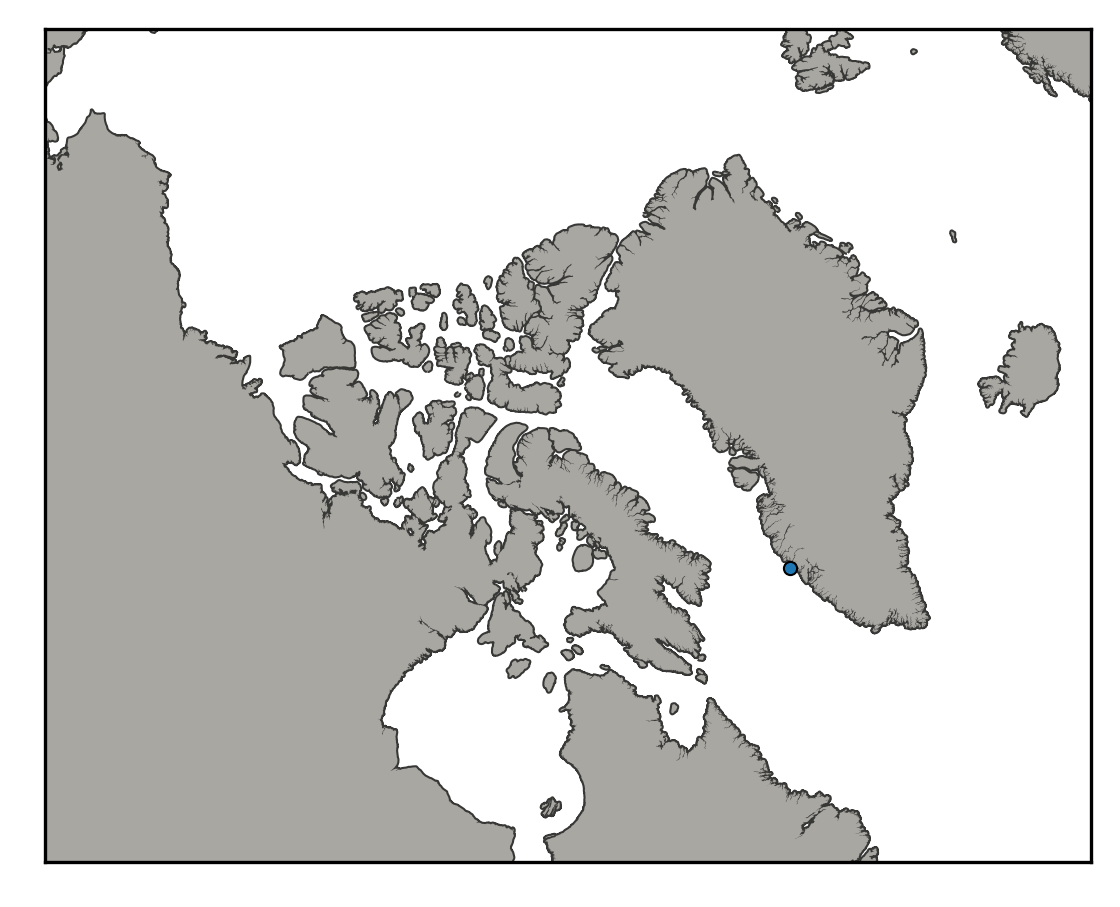

In [47]:
fig, ax1, proj1 = pickle.load(open('/ocean/brogalla/GEOTRACES/pickles/pb-surface.pickle','rb'))

x, y = proj1(mesh_lon[imin:imax,jmin:jmax], mesh_lat[imin:imax,jmin:jmax]) 
proj1.scatter(x[117,450], y[117,450], s=10, edgecolor='k', linewidth=0.5, zorder=5)
    
#     ax1.set_title(f'Depth: {mesh_depth[layer]:.1f} m', fontsize=6)

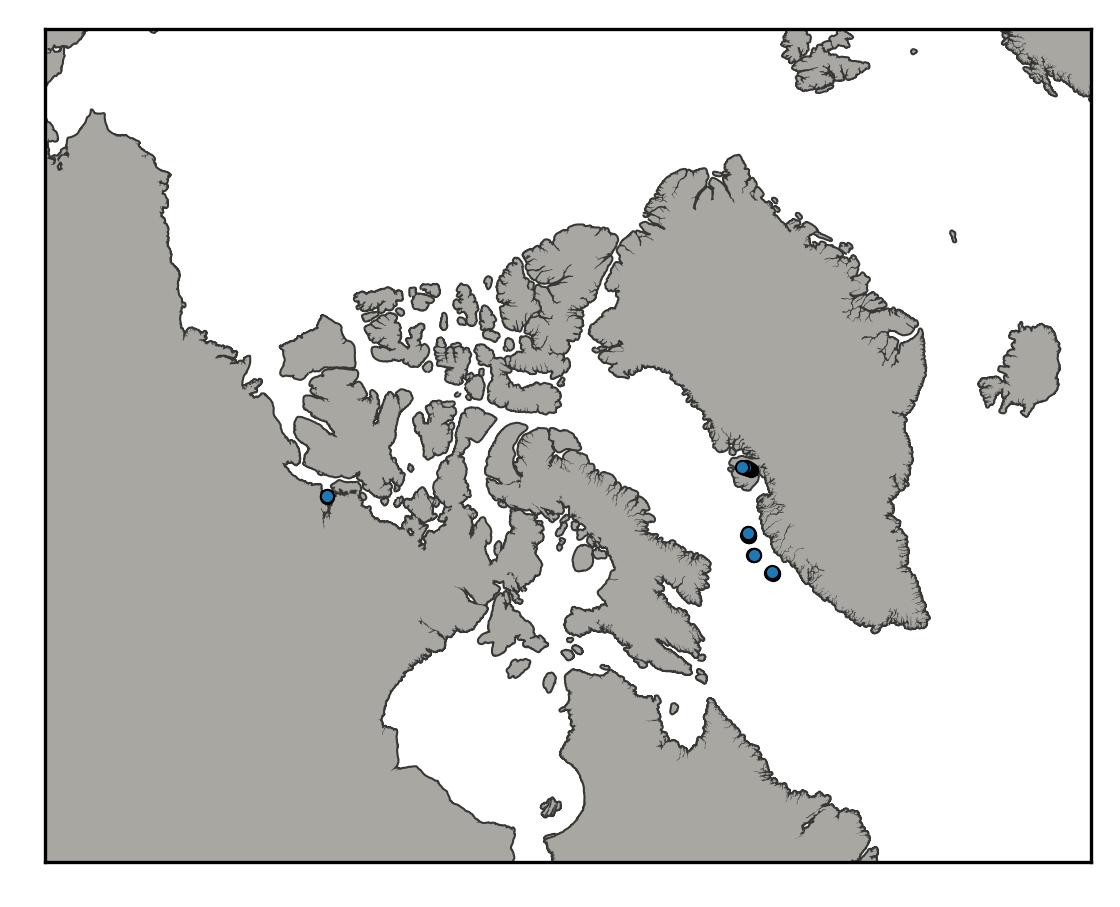

In [49]:
plot_layer(dpb_neg_loc, vmin=-1e-20, vmax=0)

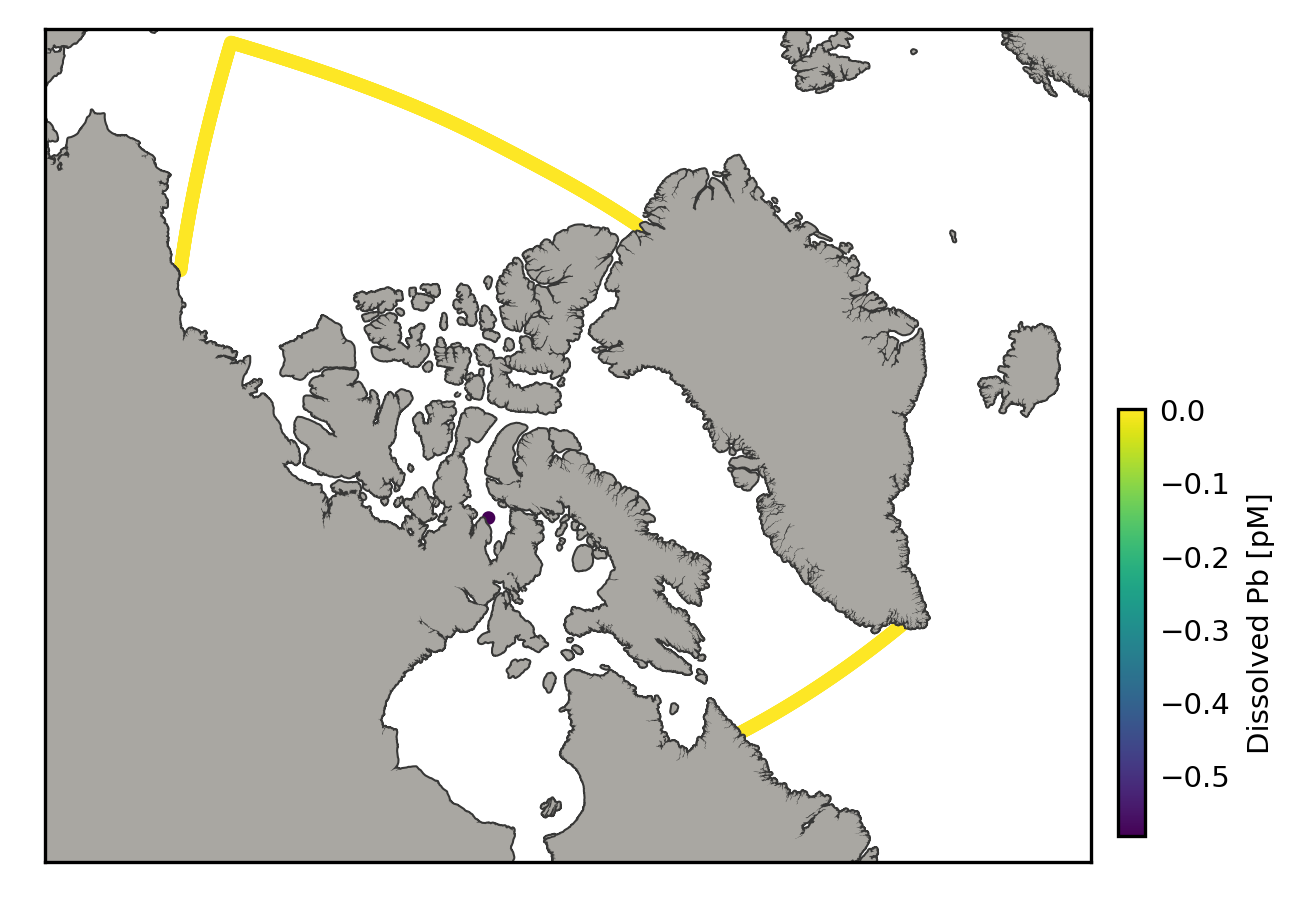

In [12]:
plot_weird(dpb, 16)

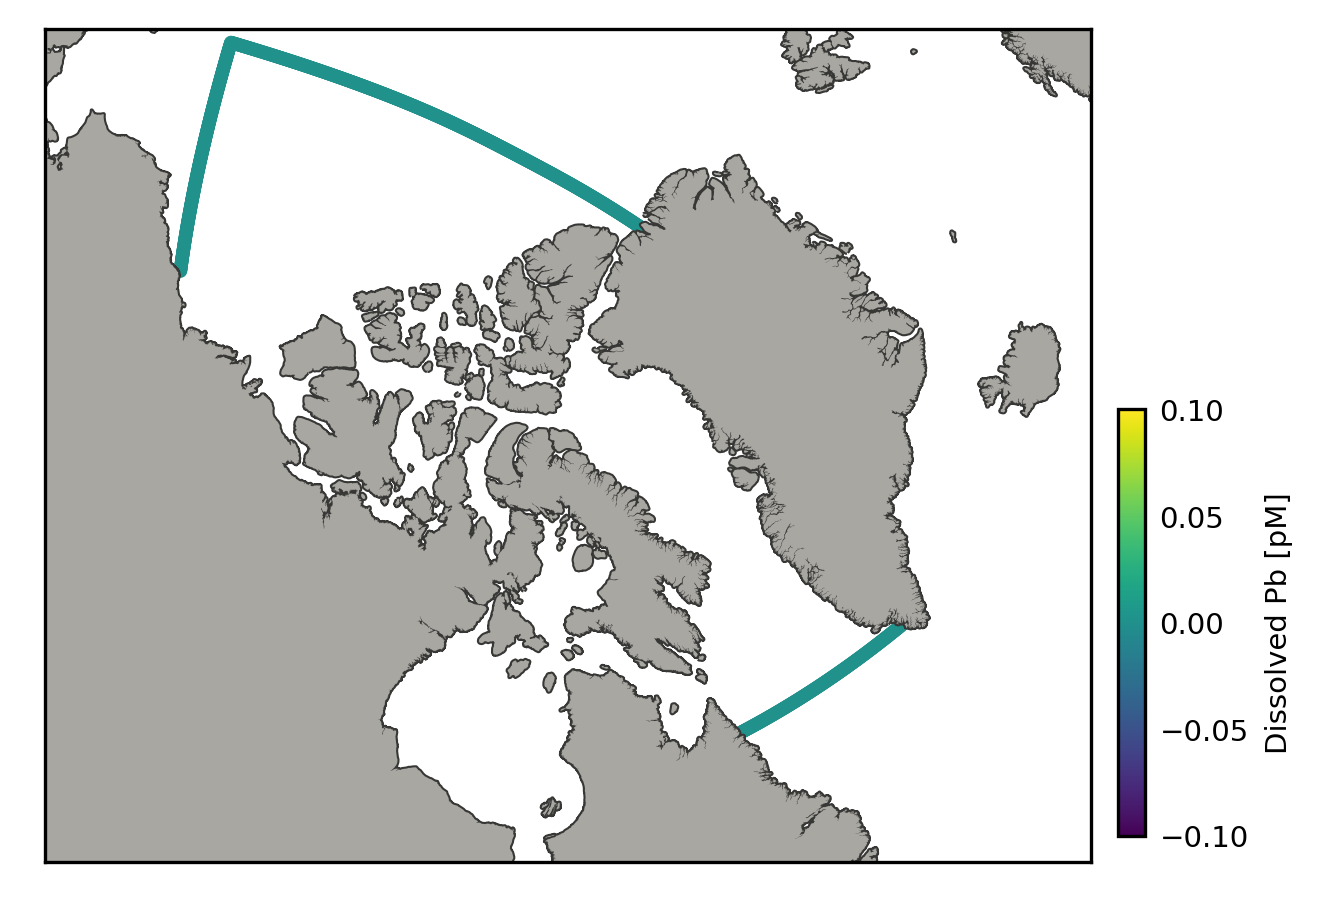

In [18]:
# resus
plot_weird(dpb, 15)

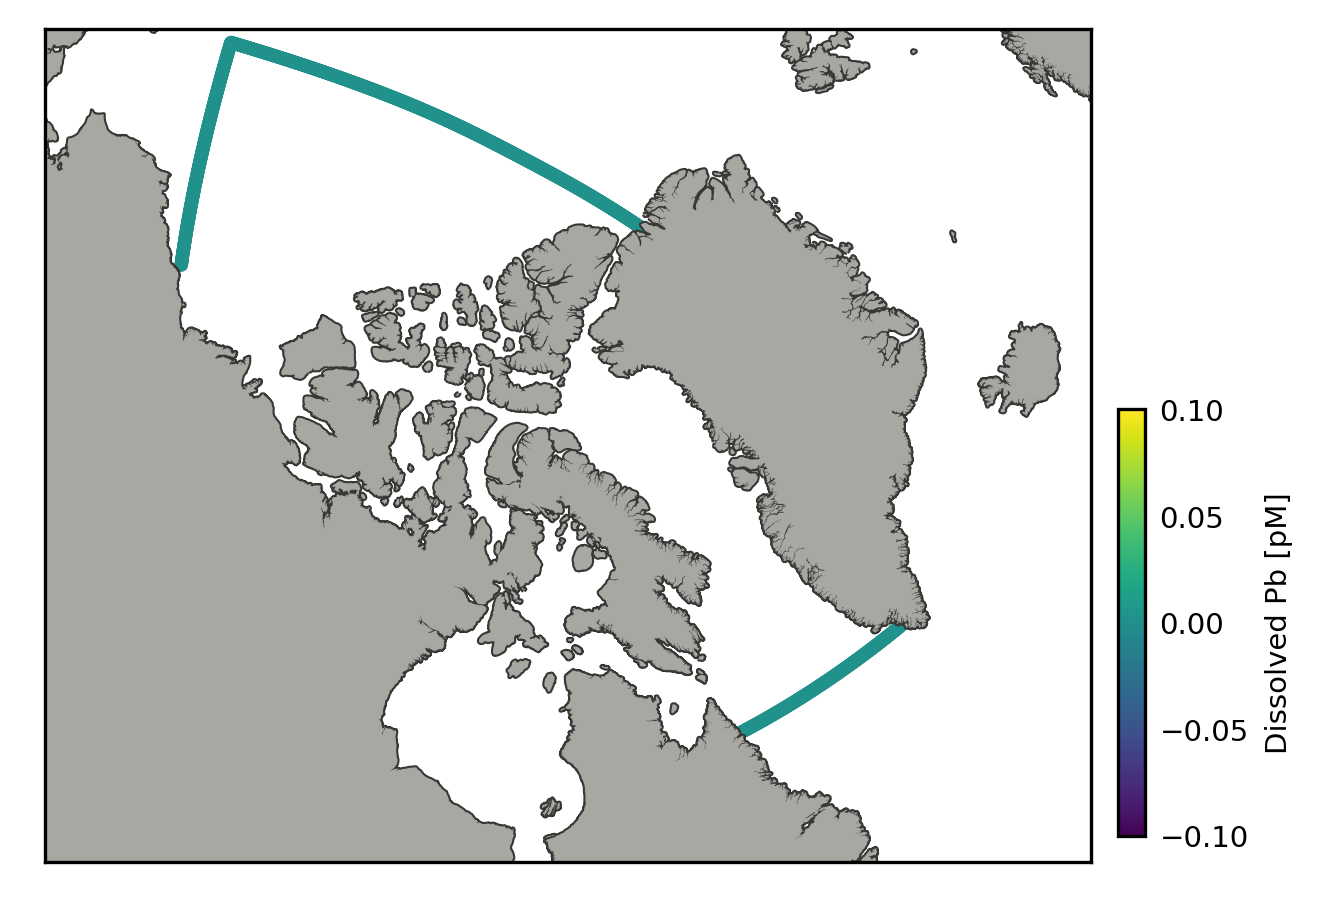

In [66]:
# sedice
plot_weird(dpb, 17)

#### Depth profiles

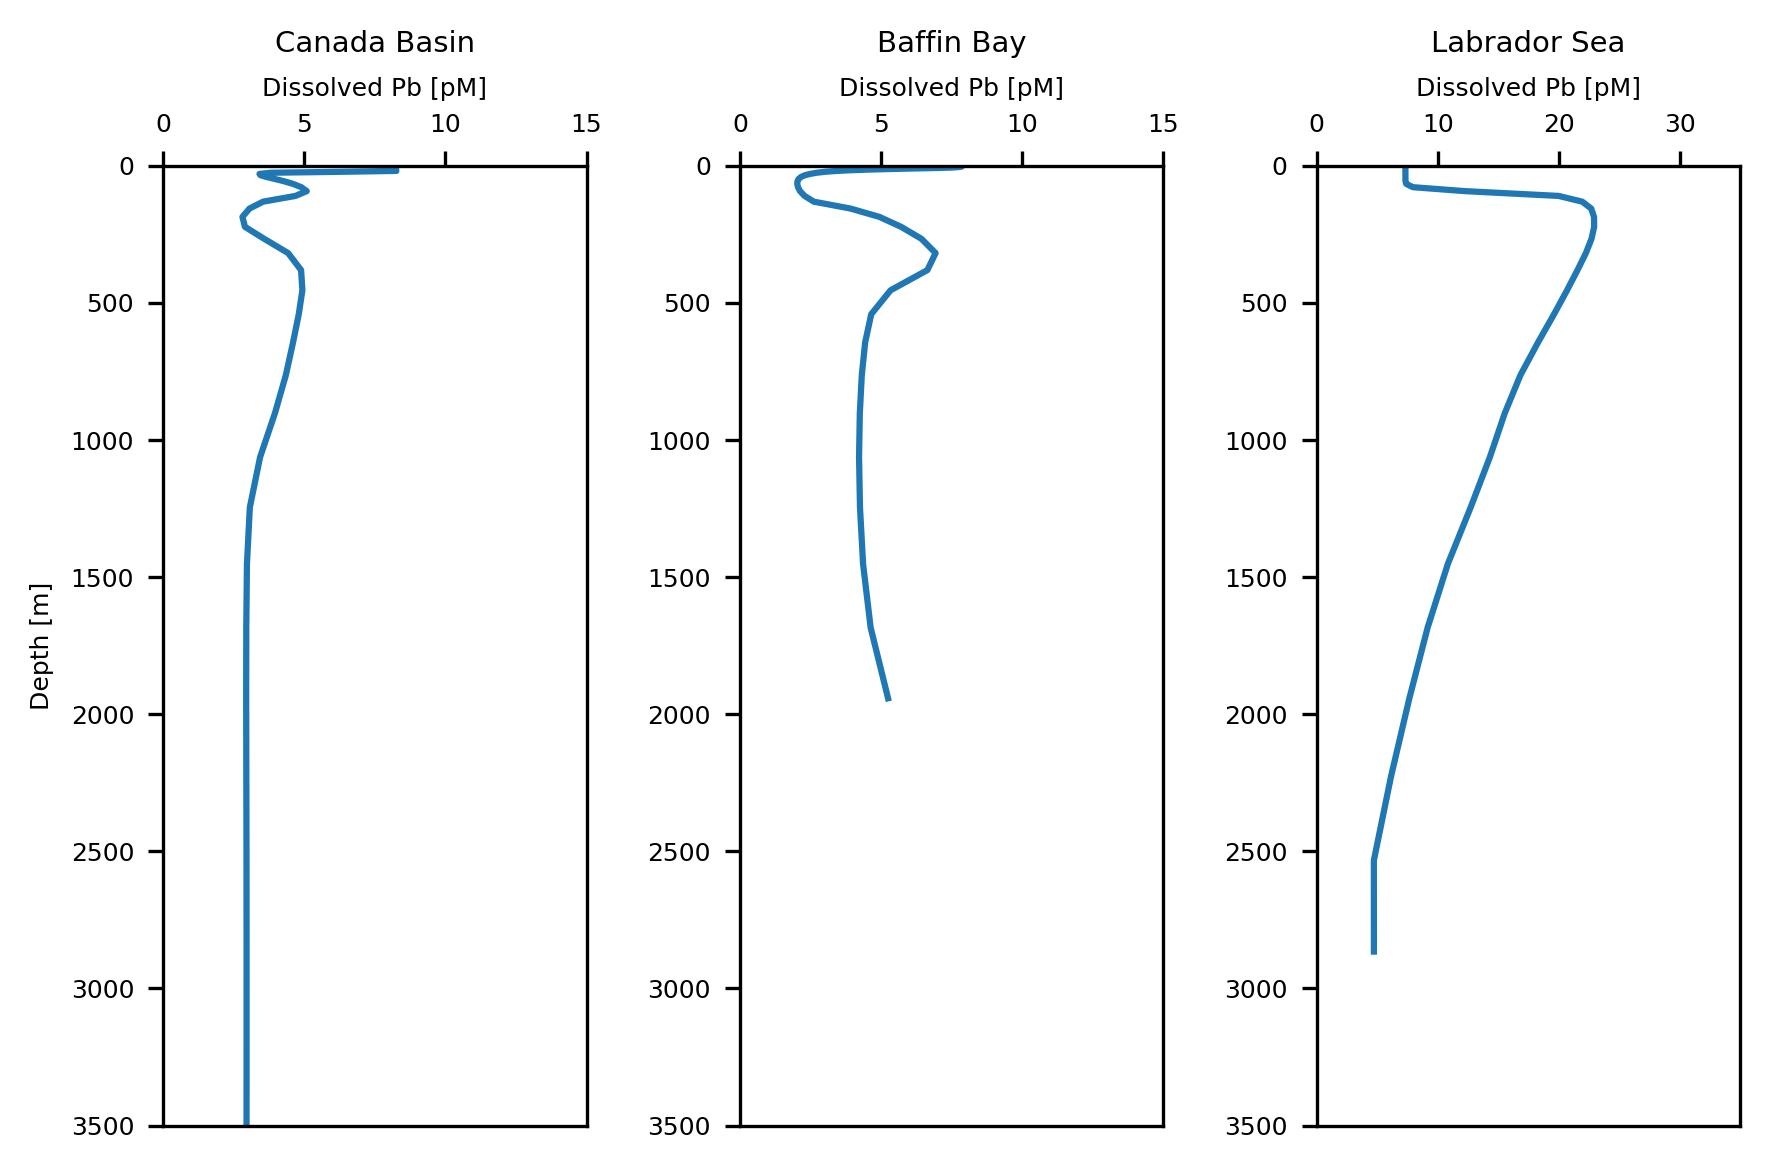

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(6,4), dpi=300)
for axis in ax.ravel():
    axis.tick_params(axis='both', labelsize=6)
    axis.invert_yaxis()
    axis.set_xlabel('Dissolved Pb [pM]', fontsize=6)
    axis.xaxis.tick_top()
    axis.xaxis.set_label_position('top') 
    axis.set_xlim(0,15)
    axis.set_ylim(3500,0)
    
ax[2].set_xlim(0,35)

ax[0].set_ylabel('Depth [m]', fontsize=6)
ax[0].set_title('Canada Basin', fontsize=7)
ax[1].set_title('Baffin Bay', fontsize=7)
ax[2].set_title('Labrador Sea', fontsize=7)

ax[0].plot(dpb[:,900,450]*1e12, mesh_depth) # CB
ax[1].plot(dpb[:,280,420]*1e12, mesh_depth) # BB
ax[2].plot(dpb[:,50,400]*1e12, mesh_depth)  # LS

plt.tight_layout()